In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
# import pyvista as pv
import SimpleITK as sitk
import scipy
# from stl import mesh
import sys
# import stltovoxel
from scipy.ndimage import zoom
from skimage import filters
from skimage import exposure
import skimage.morphology as morph
from MedtoolFunctions import medtool_functions as mf

In [2]:
# Functions
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage_ = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage_)
    ct_scan = np.transpose(ct_scan, (2, 1, 0))

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin_ = np.array(list(reversed(itkimage_.GetOrigin())))

    # Read the spacing along each dimension
    spacing_ = np.array(list(reversed(itkimage_.GetSpacing())))

    # ct_trans = np.transpose(ct_scan, (1, 0, 2))
    # ct_trans = ct_trans.astype(np.short)

    return ct_scan, origin_, spacing_

In [3]:
# Load the bone file for implantation

specimens = open('/home/biomech/Documents/01_Icotec/Specimens.txt', 'r').read().splitlines()  # Read specimens
specimen_no = 2
model_code = '04'
# defines the size of the gap in voxels
blow = 0
Zoom = 0.5  # resample, 0.5 = from 61 to 122 um
amplitude = 4  # displacement amplitude, just enter absolute value
specimen = specimens[specimen_no]
print(specimen)

S131318_L1_left


In [4]:
peek_samples = [2, 5, 7, 8, 10, 13, 15, 16, 18, 21, 23, 24, 26, 29, 31, 32]  # without 0
ti_samples = [3, 4, 6, 9, 11, 12, 14, 17, 19, 20, 22, 25, 27, 28, 30, 33]  # without 1

if specimen_no in peek_samples:
    mat = 'P'
    screw = 'LowStiffness'
elif specimen_no in ti_samples:
    mat = 'T'
    screw = 'DPS'
else:
    exit()

file = specimen + '_screw_image.mhd'  # PEEK
path_bone = '/home/biomech/Documents/01_Icotec/01_Experiments/02_Scans/' +\
            specimen + '/04_Registered/'  # PEEK

filepath = path_bone + file
print(specimen)
# load bone sample
data_orig = load_itk(filepath)
data_img_orig = data_orig[0]
print(data_img_orig.shape)
print('Material: ' + mat)

S131318_L1_left
(502, 802, 1228)
Material: P


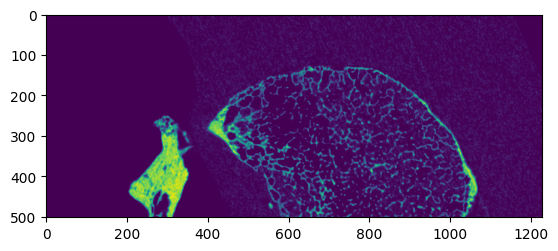

In [5]:
plt.imshow(data_img_orig[:, int(data_img_orig.shape[1]/2), :])

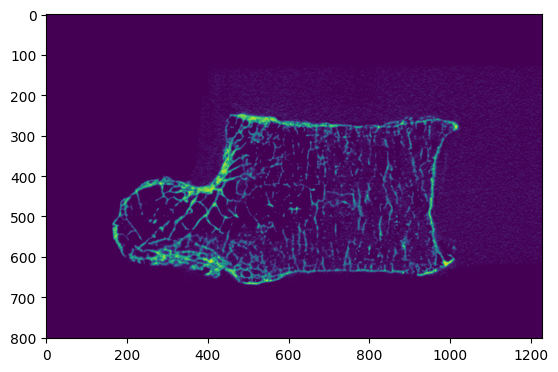

In [6]:
plt.imshow(data_img_orig[int(data_img_orig.shape[0]/2), :, :])

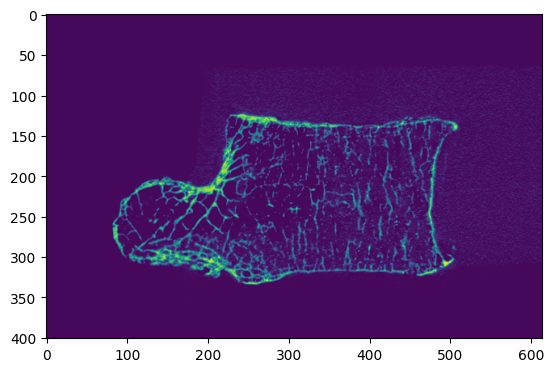

In [7]:
data_img = scipy.ndimage.zoom(data_img_orig, Zoom)
plt.imshow(data_img[int(data_img.shape[0]/2), :, :])
reso = data_orig[2] / Zoom

### Create mask for virtual implantation / insertion


In [8]:
path_implant = '/home/biomech/Documents/01_Icotec/02_FEA/02_uFE/99_Templates/'

implant = screw + 'Screw_v0_closed.mhd'
Ximplant = screw + 'Screw_v0_can.mhd'

imp_data_orig = load_itk(path_implant + implant)
Ximp_data_orig = load_itk(path_implant + Ximplant)
imp_img = scipy.ndimage.zoom(imp_data_orig[0], Zoom)
mask_can = scipy.ndimage.zoom(Ximp_data_orig[0], Zoom)
if 'DPS' in implant:
    imp_img = np.rot90(imp_img, k=2, axes=(1, 2))
    mask_can = np.rot90(mask_can, k=2, axes=(1, 2))
print(imp_img.shape)

(66, 66, 412)


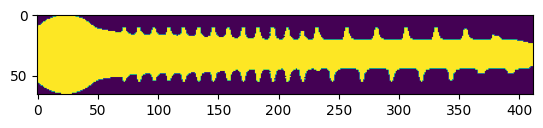

In [9]:
plt.imshow(imp_img[:, int(imp_img.shape[1]/2), :])

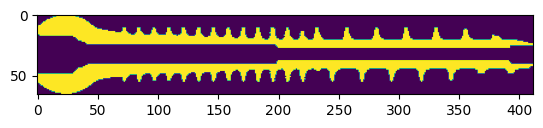

In [10]:
plt.imshow(mask_can[:, int(mask_can.shape[1]/2), :])

In [11]:
#L_tot * 0.072

In [12]:
#imp_img.shape, L_tot

In [13]:
# Enlargement of the implant - so there will be a small gap between implant and bone for the start of the simulation

add_l = np.zeros([imp_img.shape[0], imp_img.shape[1], blow])
mask = np.concatenate([add_l, imp_img, add_l], 2)
mask_can = np.concatenate([add_l, mask_can, add_l], 2)

add_x = np.zeros([blow, mask.shape[1], mask.shape[2]])
mask = np.concatenate([add_x, mask, add_x], 0)
mask_can = np.concatenate([add_x, mask_can, add_x], 0)

add_y = np.zeros([mask.shape[0], blow, mask.shape[2]])
mask = np.concatenate([add_y, mask, add_y], 1)
mask_can = np.concatenate([add_y, mask_can, add_y], 1)

footprint = morph.ball(blow)
mask_zoom = morph.dilation(mask, footprint)

diff_mask = mask_zoom - mask

print(imp_img.shape, mask_zoom.shape, mask.shape, mask_can.shape)

(66, 66, 412) (66, 66, 412) (66, 66, 412) (66, 66, 412)


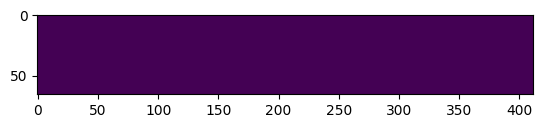

In [14]:
plt.imshow(diff_mask[:, int(diff_mask.shape[1]/2), :])

(66, 66, 412)


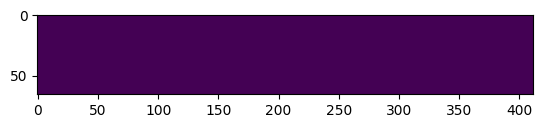

In [15]:
plt.imshow(diff_mask[int(diff_mask.shape[0]/2), : ,  :])
print(diff_mask.shape)

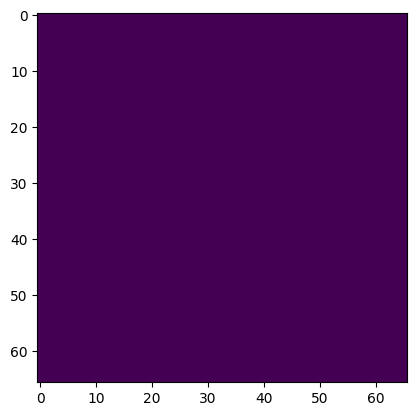

In [16]:
plt.imshow(diff_mask[ : , :, int(diff_mask.shape[2]/2)])

In [17]:
# Match the mask to the same size as the bone
# Real origin
Orig_vox = [np.rint(-data_orig[1]/reso).astype(int)[2],
            np.rint(-data_orig[1]/reso).astype(int)[1],
            np.rint(-data_orig[1]/reso).astype(int)[0]]
orig_vox = [Orig_vox[0], Orig_vox[1], Orig_vox[2]-blow]
print(Orig_vox)
print(orig_vox)
print(mask_zoom.shape)
print(mask.shape)
print(data_img.shape)

[156, 266, 431]
[156, 266, 431]
(66, 66, 412)
(66, 66, 412)
(251, 401, 614)


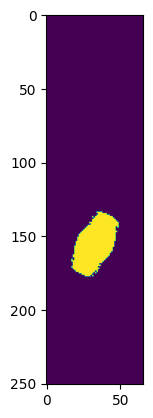

In [18]:
add1 = np.zeros([orig_vox[0] - int(mask_zoom.shape[0]/2), mask_zoom.shape[1], mask_zoom.shape[2]])
add2 = np.zeros([data_img.shape[0] - orig_vox[0] - int(mask_zoom.shape[0]/2), mask_zoom.shape[1], mask_zoom.shape[2]])
mask_zoom2 = np.concatenate([add1, mask_zoom, add2], 0)

plt.imshow(mask_zoom2[:, :, int(mask_zoom2.shape[2]/2)])


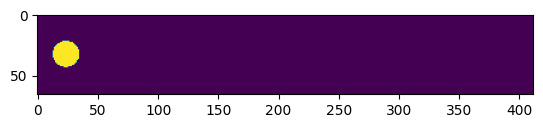

In [19]:
plt.imshow(mask_zoom2[int(mask_zoom2.shape[0]/2),: ,:])

In [20]:
mask_zoom.shape  #, add1.shape, add2.shape

(66, 66, 412)

[0.1213994 0.121399  0.121399 ]
412
431


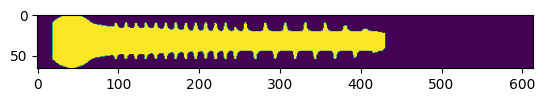

In [21]:
print(reso)
print(mask_zoom2.shape[2])
print(orig_vox[2])
## cut head of screw mask
if mask_zoom2.shape[2] > orig_vox[2]:
    mask_zoom22 = mask_zoom2[:, :, mask_zoom2.shape[2] - orig_vox[2]:]
else:
    add22 = np.zeros([mask_zoom2.shape[0], mask_zoom2.shape[1], orig_vox[2] - mask_zoom2.shape[2]])
    mask_zoom22 = np.concatenate([add22, mask_zoom2], 2)
add5 = np.zeros([mask_zoom22.shape[0], mask_zoom22.shape[1], orig_vox[2] - mask_zoom22.shape[2]])
add6 = np.zeros([mask_zoom22.shape[0], mask_zoom22.shape[1], data_img.shape[2] - orig_vox[2]])
mask_zoom3 = np.concatenate([add5, mask_zoom22, add6], 2)


plt.imshow(mask_zoom3[orig_vox[0], :, :])

In [22]:
print(mask_zoom3.shape)
print(orig_vox)

(251, 66, 614)
[156, 266, 431]


266
33.0
401


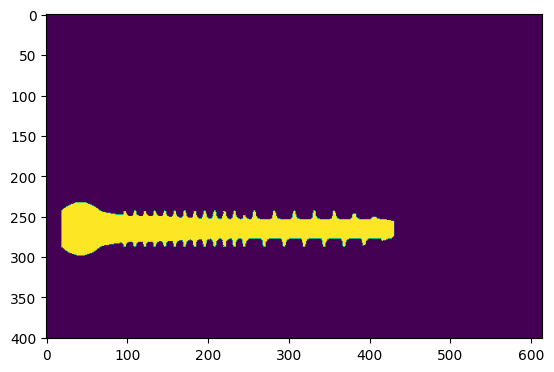

In [23]:
# Add material at the bottem
print(orig_vox[1])
print(mask_zoom3.shape[1]/2)
print(data_img.shape[1])
add3 = np.zeros([mask_zoom3.shape[0], orig_vox[1] - int(mask_zoom3.shape[1]/2), mask_zoom3.shape[2]])
add4 = np.zeros([mask_zoom3.shape[0], data_img.shape[1] - orig_vox[1] - int(mask_zoom3.shape[1]/2), mask_zoom3.shape[2]])
mask_zoom4 = np.concatenate([add3, mask_zoom3, add4], 1)

plt.imshow(mask_zoom4[orig_vox[0], :, :])

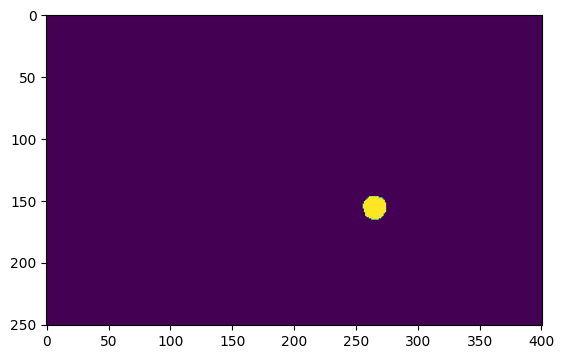

In [24]:
plt.imshow(mask_zoom4[:, :, orig_vox[2]-1])

In [25]:
mask_zoom4.shape

(251, 401, 614)

344


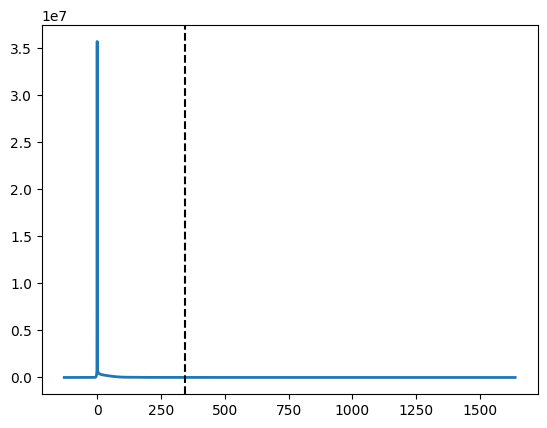

In [26]:
# Combine screw mask with bone
mask_zoom4_ = np.abs(mask_zoom4-1)
data_bvtv = np.array((data_img > 320).astype(int))
vir_img = np.array(mask_zoom4_ * data_img)

val = filters.threshold_otsu(data_img)
print(val)
hist, bins_center = exposure.histogram(data_img)
vir_bvtv = np.array((vir_img > val).astype(int))
plt.figure()
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')
plt.show()

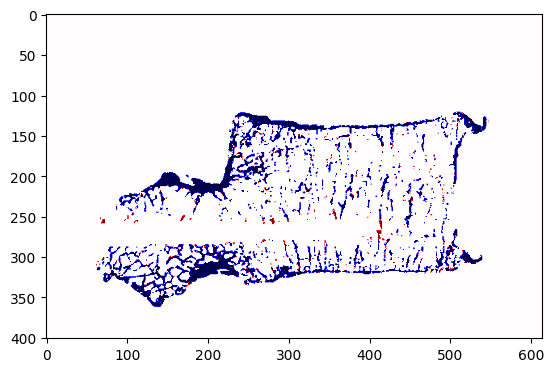

In [27]:
plt.imshow(vir_bvtv[orig_vox[0], :, :]*-2+data_bvtv[orig_vox[0], :, :], cmap='seismic')

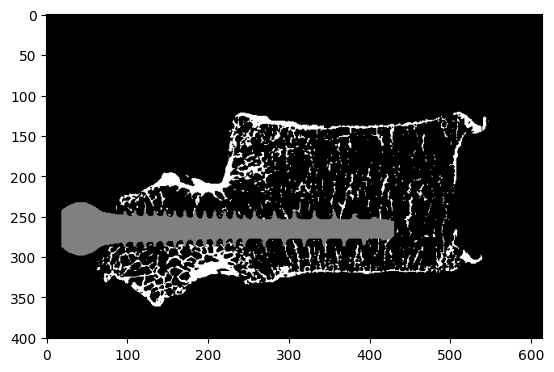

In [28]:
plt.imshow(vir_bvtv[orig_vox[0], :, :]*2 + mask_zoom4[orig_vox[0], :, :], cmap='gray')

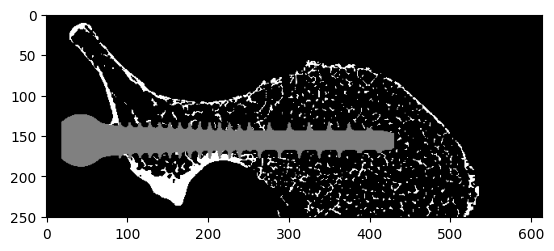

In [29]:
plt.imshow(vir_bvtv[:, orig_vox[1], :]*2 + mask_zoom4[:, orig_vox[1], :], cmap='gray')

In [30]:
print(mask.shape)
print(mask_can.shape)

(66, 66, 412)
(66, 66, 412)


In [31]:
mask_dim = [-5.75, 5.75,
            -8.75, 18.75,
            -45, 5]
roi_dim_vox = np.rint(mask_dim / reso[1]).astype(int)
orig_vox_roi = [-roi_dim_vox[0], -roi_dim_vox[2], -roi_dim_vox[4]-blow]
print(roi_dim_vox)
vir_bvtv_roi = vir_bvtv[orig_vox[0]+roi_dim_vox[0]:orig_vox[0]+roi_dim_vox[1],
                        orig_vox[1]+roi_dim_vox[2]:orig_vox[1]+roi_dim_vox[3],
                        orig_vox[2]+roi_dim_vox[4]:orig_vox[2]+roi_dim_vox[5]]
mask_zoom4_roi = mask_zoom4[orig_vox[0]+roi_dim_vox[0]:orig_vox[0]+roi_dim_vox[1],
                            orig_vox[1]+roi_dim_vox[2]:orig_vox[1]+roi_dim_vox[3],
                            orig_vox[2]+roi_dim_vox[4]:orig_vox[2]+roi_dim_vox[5]]

add1 = np.zeros([orig_vox[0] - int(mask.shape[0]/2), mask.shape[1], mask.shape[2]])
add2 = np.zeros([data_img.shape[0] - orig_vox[0] - int(mask.shape[0]/2), mask.shape[1], mask.shape[2]])
mask_roi0 = np.concatenate([add1, mask, add2], 0)
mask_roi0_can = np.concatenate([add1, mask_can, add2], 0)

add3 = np.zeros([mask_roi0.shape[0], orig_vox[1] - int(mask_roi0.shape[1]/2), mask_roi0.shape[2]])
add4 = np.zeros([mask_roi0.shape[0], data_img.shape[1] - orig_vox[1] - int(mask_roi0.shape[1]/2), mask_roi0.shape[2]])
mask_roi1 = np.concatenate([add3, mask_roi0, add4], 1)
mask_roi1_can = np.concatenate([add3, mask_roi0_can, add4], 1)


if mask_roi1.shape[2] > orig_vox[2]:
    mask_roi11 = mask_roi1[:, :, mask_roi1.shape[2] - orig_vox[2]:]
    mask_roi11_can = mask_roi1_can[:, :, mask_roi1_can.shape[2] - orig_vox[2]:]
else:
    add11 = np.zeros([mask_roi1.shape[0], mask_roi1.shape[1], orig_vox[2] - mask_roi1.shape[2]])
    mask_roi11 = np.concatenate([add11, mask_roi1], 2)
    add11_can = np.zeros([mask_roi1_can.shape[0], mask_roi1_can.shape[1], orig_vox[2] - mask_roi1_can.shape[2]])
    mask_roi11_can = np.concatenate([add11_can, mask_roi1_can], 2)

add5 = np.zeros([mask_roi11.shape[0], mask_roi11.shape[1], orig_vox[2] - mask_roi11.shape[2]])
add6 = np.zeros([mask_roi11.shape[0], mask_roi11.shape[1], data_img.shape[2] - orig_vox[2]])
mask_roi2 = np.concatenate([add5, mask_roi11, add6], 2)
mask_roi2_can = np.concatenate([add5, mask_roi11_can, add6], 2)

mask_roi = mask_roi2[orig_vox[0]+roi_dim_vox[0]:orig_vox[0]+roi_dim_vox[1],
                            orig_vox[1]+roi_dim_vox[2]:orig_vox[1]+roi_dim_vox[3],
                            orig_vox[2]+roi_dim_vox[4]:orig_vox[2]+roi_dim_vox[5]]
mask_roi_can = mask_roi2_can[orig_vox[0]+roi_dim_vox[0]:orig_vox[0]+roi_dim_vox[1],
                            orig_vox[1]+roi_dim_vox[2]:orig_vox[1]+roi_dim_vox[3],
                            orig_vox[2]+roi_dim_vox[4]:orig_vox[2]+roi_dim_vox[5]]

print(mask_zoom4_roi.shape)
print(vir_bvtv_roi.shape)
print(mask_roi.shape)
print(mask_roi_can.shape)
print(mask.shape)

[ -47   47  -72  154 -371   41]
(94, 207, 412)
(94, 207, 412)
(94, 207, 412)
(94, 207, 412)
(66, 66, 412)


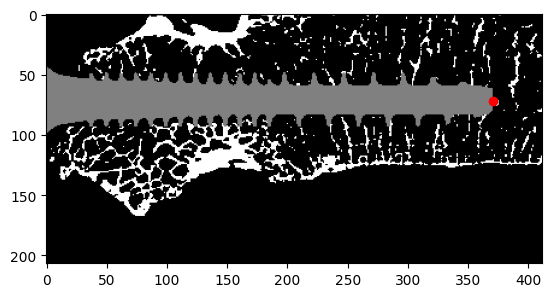

In [32]:
plt.imshow(vir_bvtv_roi[int(vir_bvtv_roi.shape[0]/2), :, :]*2 + mask_roi[int(vir_bvtv_roi.shape[0]/2), :, :], cmap='gray')
plt.scatter(orig_vox_roi[2]-blow, orig_vox_roi[1], color='r')

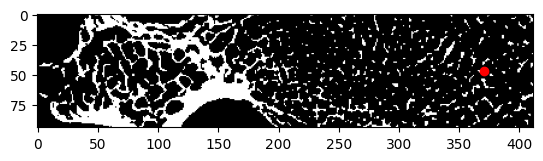

In [33]:
plt.imshow(vir_bvtv_roi[:, int(vir_bvtv_roi.shape[1]/2), :]*2 + mask_roi[:, int(vir_bvtv_roi.shape[1]/2), :], cmap='gray')
plt.scatter(orig_vox_roi[2]-blow, orig_vox_roi[0], color='r')

In [34]:
# Create .mhd of mesh image

origin = [0, 0, 0]
spacing = np.array([1, 1, 1]) * reso[1]
cylinder_trans = vir_bvtv_roi.astype(np.short)
itkimage = sitk.GetImageFromArray(np.transpose(cylinder_trans, [2, 1, 0]), isVector=None)
# here filter cylinder_trans
component_image = sitk.ConnectedComponent(itkimage)
sorted_component_image = sitk.RelabelComponent(component_image, sortByObjectSize=True)
largest_component_binary_image = sorted_component_image == 1
other_components_binary_image = sorted_component_image > 1
largest_component_binary_image.SetSpacing(spacing)
largest_component_binary_image.SetOrigin(origin)

mask_trans = mask_roi.astype(np.short)
mask_trans_can = mask_roi_can.astype(np.short)
itkmask = sitk.GetImageFromArray(np.transpose(mask_trans ,[2, 1, 0]), isVector=None)
itkmask_can = sitk.GetImageFromArray(np.transpose(mask_trans_can ,[2, 1, 0]), isVector=None)
# here filter mask_trans_can
component_image_ = sitk.ConnectedComponent(itkmask_can)
sorted_component_image_ = sitk.RelabelComponent(component_image_, sortByObjectSize=True)
largest_component_binary_image_ = sorted_component_image_ == 1
other_components_binary_image_ = sorted_component_image_ > 1

itkmask.SetSpacing(spacing)
largest_component_binary_image_.SetSpacing(spacing)
itkmask.SetOrigin(origin)
largest_component_binary_image_.SetOrigin(origin)

path_to_local_folder = '/home/biomech/Documents/01_Icotec/02_FEA/02_uFE/99_Templates/'
reso_ = '0' + str(reso[1]).split('.')[-1]
sitk.WriteImage(largest_component_binary_image, path_to_local_folder + 'Mesh_' + specimen + '_' + reso_ + '.mhd')
sitk.WriteImage(largest_component_binary_image_, path_to_local_folder + 'Implant_mask_' + reso_ + '.mhd')

In [35]:
# Here cleaning of islands

# Creat abaqus mesh

def mesh(img_, path_, storage, name, template_):
    """

    :param img_: voxel model file
    :param path_: path to voxel model
    :param storage: location of input file
    :param name: name of input file
    :param template_: template inp file
    :return:
    """
    img_ = path_ + img_

    img_, origin_, spacing_ = load_itk(img_)

    inpName = storage + name

    mf.writeAbaqusGeneral(inpName, img_, spacing_, templateFile=template_, smooth=None)

sample = specimen
path = path_to_local_folder
template = path + 'mesh_temp.inp'

img = 'Mesh_' + sample + '_' + reso_ + '.mhd'  # PEEK
mesh(img, path, path, 'Mesh_' + sample + '_' + reso_ + screw + '.inp', template)  # PEEK

 ... setup ABAQUS *.inp file from template
     -> recast model from 'B' to 'i'
     -> setup Element Data  : |==========|
     -> setup Node Data     : Done
 ... write ABAQUS *.inp file from template
     -> process Node IDs    : |==========|
     -> write Nodes         :    1373991 
     -> process Elements    : |=|
     -> write Elements      :     792577             
     -> write BCs Node Sets     
     -> Write Property      : /home/biomech/Downloads/FE_test/vumat.inp 
     -> Write finished in   :       11.8 sec  


In [36]:
template = path + 'mesh_temp.inp'

img_screw = 'Implant_mask_' + reso_ + '.mhd'
mesh(img_screw, path, path, 'Mesh_' + sample + '_' + reso_ + screw + 'screw_A01.inp', template)

 ... setup ABAQUS *.inp file from template
     -> recast model from 'B' to 'i'
     -> setup Element Data  : |==========|
     -> setup Node Data     : Done
 ... write ABAQUS *.inp file from template
     -> process Node IDs    : |==========|
     -> write Nodes         :     313389 
     -> process Elements    : |=|
     -> write Elements      :     256915             
     -> write BCs Node Sets     
     -> Write Property      : /home/biomech/Downloads/FE_test/vumat.inp 
     -> Write finished in   :        6.5 sec  


In [37]:
import os

# path = '/home/biomech/Downloads/FE_test/'
path = '/home/biomech/Documents/01_Icotec/02_FEA/02_uFE/99_Templates/'
inp_template = 'inp_temp2.inp'


inp_bone = 'Mesh_' + sample + '_' + reso_ + screw + '.inp'
inp_screw = 'Mesh_' + sample + '_' + reso_ + screw + 'screw_A01.inp'

bone_mesh = open(path + inp_bone, 'r')
screw_mesh = open(path + inp_screw, 'r')
template = open(path + inp_template, 'r')


input_file = model_code + '_' + sample + '_' + reso_ + '.inp'


try:
    os.remove(path + input_file)
except FileNotFoundError:
    print('New file.')

path_out = '/home/biomech/Documents/01_Icotec/02_FEA/02_uFE/01_MainStudy/' + specimen + '/'
isExist = os.path.exists(path_out)
if not isExist:
    os.makedirs(path_out)
isExist = os.path.exists(path_out + input_file)
if isExist:
    print('- - - FILE ALREADY EXISTS, DO YOU WANT TO REPLACE IT? [y/n] - - -')
    answer = input()
    if answer != 'y':
        sys.exit()

outfile = open(path_out + input_file, 'w')


for lines in template:
    if '** Import Bone' in lines:
        outfile.write('** Bone mesh inserted\n')
        for line in bone_mesh:
            if '*ELEMENT, TYPE=C3D8, ELSET=SET1' in line:
                outfile.write('*ELEMENT, TYPE=C3D8, ELSET=SET-BONE\n')
            elif '*HEADING' in line:
                print('*HEADING removed.')
            elif 'CP3: CUBE' in line:
                print('CP3: CUBE removed.')
            elif '*NSET, NSET=ALL_NODE_T' in line:
                outfile.write('*Nset, nset=ALL_NODE_TB\n')
            elif '*NSET, NSET=ALL_NODE_B' in line:
                print('Combining node sets.')
            else:
                outfile.write(line)
        outfile.write('\n**\n')
    elif '** Import Impl' in lines:
        outfile.write('** Impl mesh inserted\n')
        for line in screw_mesh:
            if '*ELEMENT, TYPE=C3D8, ELSET=SET1' in line:
                outfile.write('*ELEMENT, TYPE=C3D8, ELSET=SET-IMPL\n')
            elif '*HEADING' in line:
                print('*HEADING removed.')
            elif 'CP3: CUBE' in line:
                print('CP3: CUBE removed.')
            else:
                outfile.write(line)
        outfile.write('\n**\n')
    elif '*Solid Section, elset=SET-IMPL, material=PEEK' in lines:
        if mat == 'P':
            outfile.write(lines)
        elif mat == 'T':
            outfile.write('*Solid Section, elset=SET-IMPL, material=Ti\n')
    elif 'Set-RP, 2, 2, -16' in lines:
        outfile.write('Set-RP, 2, 2, -' + str(amplitude) + '\n')
    else:
        outfile.write(lines)
outfile.close()
os.remove(path + inp_bone)
os.remove(path + inp_screw)
os.remove(path + 'Implant_mask_' + reso_ + '.mhd')
os.remove(path + 'Implant_mask_' + reso_ + '.raw')
os.remove(path + 'Mesh_' + specimen + '_' + reso_ + '.mhd')
os.remove(path + 'Mesh_' + specimen + '_' + reso_ + '.raw')

New file.
*HEADING removed.
CP3: CUBE removed.
Combining node sets.
*HEADING removed.
CP3: CUBE removed.
